# Kmeans on wavelet transforms from concatenated session

In [16]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [17]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from one.api import ONE

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood

one = ONE(mode='remote')

## Load supersession

In [18]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/2_fit_models/Wavelets/'
filename = str(results_path + 'supersession_wavelets08-20-2025')
super_session = np.load(open(filename, 'rb'))

## k selection with GMM model comparison

In [19]:
repeats = 5
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(super_session.copy(), components)
kneedle = KneeLocator(components[1:], np.nanmean(LLs, axis=0)[1:], curve="convex", direction="decreasing")
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee


In [17]:
file_to_save = LLs.copy()
filename = 'LLs_GMM_1_11_components'
save_path = '/home/ines/repositories/representation_learning_variability/Models/Maths intuitions/Wavelets/'
file_format = 'npy'
script_name = 'kmeans_supersession.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

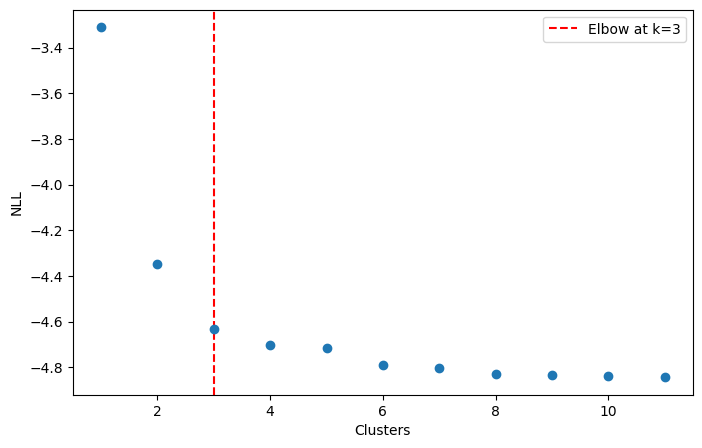

In [20]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

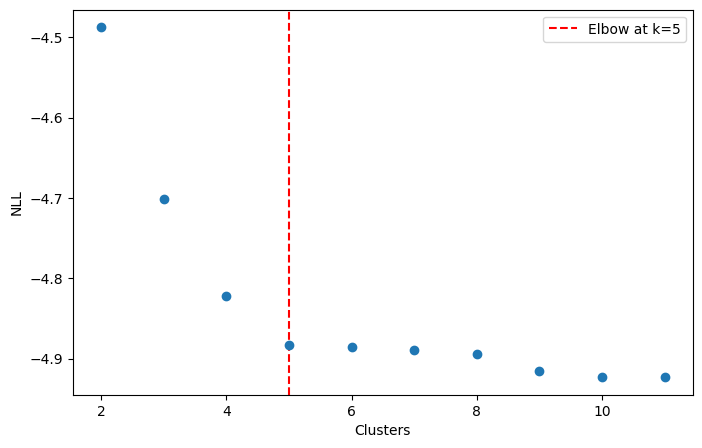

In [11]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components[1:], np.nanmean(LLs, axis=0)[1:], np.nanstd(LLs, axis=0)[1:]/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

In [3]:
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

NameError: name 'components' is not defined

### kMeans on supersession

In [5]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans.fit(super_session.copy())
centroids = kmeans.cluster_centers_

In [6]:
# Save centroid results
file_to_save = centroids.copy()
filename = str('centroids_supersession_wavelets_k_'+str(optimal_k))
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/Wavelets/'
file_format = 'npy'
script_name = 'kmeans_supersession.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

### Predict clusters of unseen data and save

In [7]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_train_batches = 20

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.5',
    '1.0', '2.0', '4.0', '8.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 4]
idx_end_list = [1, 2, 3, 9]

var_interest = 'wavelet'

In [8]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

In [9]:

index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    # Get session data
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]
    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]

    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)

    """ Save states per design_matrix """

    # Save most_likely_states
    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/wavelet_transform_states/'
    pickle.dump(states, open(states_results_path + "most_likely_states" + '_'+str(optimal_k)+'_'+ fit_id , "wb"))
